In [39]:
import rasterio
import numpy as np
import matplotlib.pyplot as plt

path_index_h = "data/NDBI_20m.img"
path_index_c = "data/NDBI_100m.img"
path_temperature_c = "data/LST_100m.img" 

################### Index H ##########################################

with rasterio.open(path_index_h) as dataset:
    I_H = dataset.read(1).astype(np.float32) 
    cols = dataset.width
    rows = dataset.height

################### Temperature C ######################################

with rasterio.open(path_temperature_c) as dataset:
    T_C = dataset.read(1).astype(np.float32)
    cols_temp = dataset.width
    rows_temp = dataset.height

################### Index C ##########################################

with rasterio.open(path_index_c) as dataset:
    I_C = dataset.read(1).astype(np.float32)
    cols_c = dataset.width
    rows_c = dataset.height

    ################### Geographic data ##########################################
    projection_C = dataset.crs
    geotransform_C = dataset.transform

In [40]:
import torch.nn.functional as F

def pad_to_multiple(x, multiple=16):
    _, _, h, w = x.shape
    pad_h = (multiple - h % multiple) % multiple
    pad_w = (multiple - w % multiple) % multiple
    # padding: (left, right, top, bottom)
    return F.pad(x, (0, pad_w, 0, pad_h))

In [41]:
import torch
from torch.utils.data import DataLoader, Dataset

cuda = True if torch.cuda.is_available() else False
dev = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Normalization
sIc=np.std(I_C)
sTc=np.std(T_C)
mIc=np.mean(I_C)
mTc=np.mean(T_C)
I_C=(I_C-np.mean(I_C))/np.std(I_C)
T_C=(T_C-np.mean(T_C))/np.std(T_C)

#Create dataloader
signals_all = np.stack((I_C, T_C), axis=0)
signals_all = signals_all[np.newaxis, :, :, :] 

class TrajDataSet(Dataset):
    def __init__(self,  traj, transform=None):
        self.traj = traj
        self.transform = transform

    def __len__(self):
        return self.traj.shape[0]

    def __getitem__(self, idx):
        # select coordinates
        sample = self.traj[idx,:,:]
        if self.transform:
            sample = self.transform(sample)

        return sample

class ToTensor(object):
    """Convert ndarrays in sample to Tensors."""
    def __call__(self, sample):
        if(cuda):
            return torch.FloatTensor(sample).cuda()
        else:
            return torch.FloatTensor(sample)
        #return torch.FloatTensor(sample)

# hyperparameters
batch_size = 128
batches=signals_all.shape[0]/batch_size

## reduce size dataset
train_set = TrajDataSet(signals_all, transform= ToTensor())
train_loader = DataLoader(train_set, batch_size=batch_size, num_workers = 0, shuffle = True, drop_last=False)

In [73]:

import torch
import torch.nn as nn

class UNet(nn.Module):
    def __init__(self, in_channels=2, out_channels=1, init_features=32, use_groupnorm=True):
        super(UNet, self).__init__()

        features = init_features
        norm_layer = lambda num_features: nn.GroupNorm(1, num_features) if use_groupnorm else nn.BatchNorm2d(num_features)

        self.encoder1 = UNet._block(in_channels, features, norm_layer, name="enc1")
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.encoder2 = UNet._block(features, features * 2, norm_layer, name="enc2")
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.encoder3 = UNet._block(features * 2, features * 4, norm_layer, name="enc3")
        self.pool3 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.encoder4 = UNet._block(features * 4, features * 8, norm_layer, name="enc4")
        self.pool4 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.bottleneck = UNet._block(features * 8, features * 16, norm_layer, name="bottleneck")

        self.upconv4 = nn.ConvTranspose2d(features * 16, features * 8, kernel_size=2, stride=2)
        self.decoder4 = UNet._block(features * 8 * 2, features * 8, norm_layer, name="dec4")
        self.upconv3 = nn.ConvTranspose2d(features * 8, features * 4, kernel_size=2, stride=2)
        self.decoder3 = UNet._block(features * 4 * 2, features * 4, norm_layer, name="dec3")
        self.upconv2 = nn.ConvTranspose2d(features * 4, features * 2, kernel_size=2, stride=2)
        self.decoder2 = UNet._block(features * 2 * 2, features * 2, norm_layer, name="dec2")
        self.upconv1 = nn.ConvTranspose2d(features * 2, features, kernel_size=2, stride=2)
        self.decoder1 = UNet._block(features * 2, features, norm_layer, name="dec1")

        self.conv = nn.Conv2d(features, out_channels, kernel_size=1)

    def forward(self, x):
        enc1 = self.encoder1(x)
        enc2 = self.encoder2(self.pool1(enc1))
        enc3 = self.encoder3(self.pool2(enc2))
        enc4 = self.encoder4(self.pool3(enc3))

        bottleneck = self.bottleneck(self.pool4(enc4))

        dec4 = self.upconv4(bottleneck)
        dec4 = torch.cat((dec4, enc4), dim=1)
        dec4 = self.decoder4(dec4)

        dec3 = self.upconv3(dec4)
        dec3 = torch.cat((dec3, enc3), dim=1)
        dec3 = self.decoder3(dec3)

        dec2 = self.upconv2(dec3)
        dec2 = torch.cat((dec2, enc2), dim=1)
        dec2 = self.decoder2(dec2)

        dec1 = self.upconv1(dec2)
        dec1 = torch.cat((dec1, enc1), dim=1)
        dec1 = self.decoder1(dec1)

        return self.conv(dec1)

    @staticmethod
    def _block(in_channels, features, norm_layer, name):
        return nn.Sequential(
            nn.Conv2d(in_channels, features, kernel_size=3, padding=1, bias=False),
            norm_layer(features),
            nn.ReLU(inplace=True),
            nn.Conv2d(features, features, kernel_size=3, padding=1, bias=False),
            norm_layer(features),
            nn.ReLU(inplace=True),
        )
        
        
import torch
import torch.nn as nn
import torch.nn.functional as F

class UNetResidual(nn.Module):
    def __init__(self):
        super().__init__()

        def conv_block(in_c, out_c):
            return nn.Sequential(
                nn.Conv2d(in_c, out_c, 3, padding=1),
                nn.ReLU(inplace=True),
                nn.Conv2d(out_c, out_c, 3, padding=1),
                nn.ReLU(inplace=True),
            )

        self.enc1 = conv_block(1, 64)
        self.enc2 = conv_block(64, 128)
        self.enc3 = conv_block(128, 256)

        self.pool = nn.MaxPool2d(2)

        self.bottleneck = conv_block(256, 512)

        self.up3 = nn.ConvTranspose2d(512, 256, 2, stride=2)
        self.dec3 = conv_block(512, 256)

        self.up2 = nn.ConvTranspose2d(256, 128, 2, stride=2)
        self.dec2 = conv_block(256, 128)

        self.up1 = nn.ConvTranspose2d(128, 64, 2, stride=2)
        self.dec1 = conv_block(128, 64)

        self.final = nn.Conv2d(64, 1, 1)

    def forward(self, x):
        e1 = self.enc1(x)
        e2 = self.enc2(self.pool(e1))
        e3 = self.enc3(self.pool(e2))

        b = self.bottleneck(self.pool(e3))

        d3 = self.dec3(torch.cat([self.up3(b), e3], dim=1))
        d2 = self.dec2(torch.cat([self.up2(d3), e2], dim=1))
        d1 = self.dec1(torch.cat([self.up1(d2), e1], dim=1))

        out = self.final(d1)
        return out


In [87]:
from torch import nn
from torch import optim

def weights_init(m):
    """
    This function initializes the model weights randomly from a 
    Normal distribution. This follows the specification from the DCGAN paper.
    https://arxiv.org/pdf/1511.06434.pdf
    Source: https://pytorch.org/tutorials/beginner/dcgan_faces_tutorial.html
    """
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)

# create network
model = UNet().to(dev)

# weight initialization
model = model.apply(weights_init)

# define loss and optimizers
criterion = nn.MSELoss().to(dev)
lr = 0.02
optimizer = optim.Adam(model.parameters(),lr= lr, betas=(0.5, 0.999))

Epoch 1/60 - Loss: 1.003943
Epoch 2/60 - Loss: 0.851349
Epoch 3/60 - Loss: 0.741046
Epoch 4/60 - Loss: 0.646979
Epoch 5/60 - Loss: 0.563374
Epoch 6/60 - Loss: 0.489359
Epoch 7/60 - Loss: 0.424438
Epoch 8/60 - Loss: 0.370054
Epoch 9/60 - Loss: 0.324764
Epoch 10/60 - Loss: 0.286420
Epoch 11/60 - Loss: 0.254559
Epoch 12/60 - Loss: 0.227960
Epoch 13/60 - Loss: 0.205715
Epoch 14/60 - Loss: 0.187200
Epoch 15/60 - Loss: 0.170903
Epoch 16/60 - Loss: 0.156495
Epoch 17/60 - Loss: 0.143566
Epoch 18/60 - Loss: 0.131901
Epoch 19/60 - Loss: 0.121257
Epoch 20/60 - Loss: 0.111207
Epoch 21/60 - Loss: 0.101957
Epoch 22/60 - Loss: 0.093289
Epoch 23/60 - Loss: 0.085208
Epoch 24/60 - Loss: 0.078075
Epoch 25/60 - Loss: 0.071744
Epoch 26/60 - Loss: 0.065859
Epoch 27/60 - Loss: 0.060438
Epoch 28/60 - Loss: 0.055542
Epoch 29/60 - Loss: 0.051102
Epoch 30/60 - Loss: 0.047037
Epoch 31/60 - Loss: 0.043200
Epoch 32/60 - Loss: 0.039607
Epoch 33/60 - Loss: 0.036261
Epoch 34/60 - Loss: 0.033237
Epoch 35/60 - Loss: 0.0

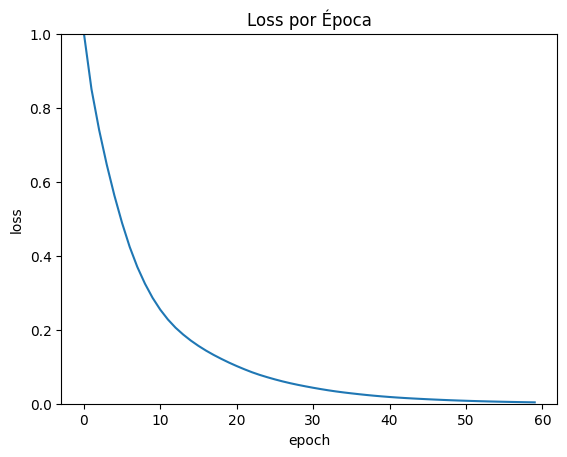

In [88]:
import matplotlib.pyplot as plt  

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = UNet().to(device)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

train_set = TrajDataSet(signals_all)
train_loader = DataLoader(train_set, batch_size=1, shuffle=True)

num_epochs = 60
cout = [] 

for epoch in range(num_epochs):
    model.train()
    total_loss = 0
    for batch in train_loader:
        optimizer.zero_grad()
        
        inputs = batch.to(device)
        inputs = pad_to_multiple(inputs, multiple=16) 
    
        target = inputs[:, 1:2, :, :]
        
        outputs = model(inputs)
        
        loss = criterion(outputs, target)
        loss.backward()
        optimizer.step()
        
        total_loss += loss.item()
    
    avg_loss = total_loss / len(train_loader)
    cout.append(avg_loss) 
    print(f"Epoch {epoch+1}/{num_epochs} - Loss: {avg_loss:.6f}")
    
    if avg_loss < 0.01:
        torch.save(model.state_dict(), f"./Model_epoch_{epoch+1}.pt")

plt.figure()
plt.plot(cout)
plt.ylabel("loss")
plt.xlabel("epoch")
plt.ylim(0, 1)
plt.title("Loss por Época")
plt.show()

In [89]:
pred = model(inputs).cpu().detach().numpy().reshape((32,32))

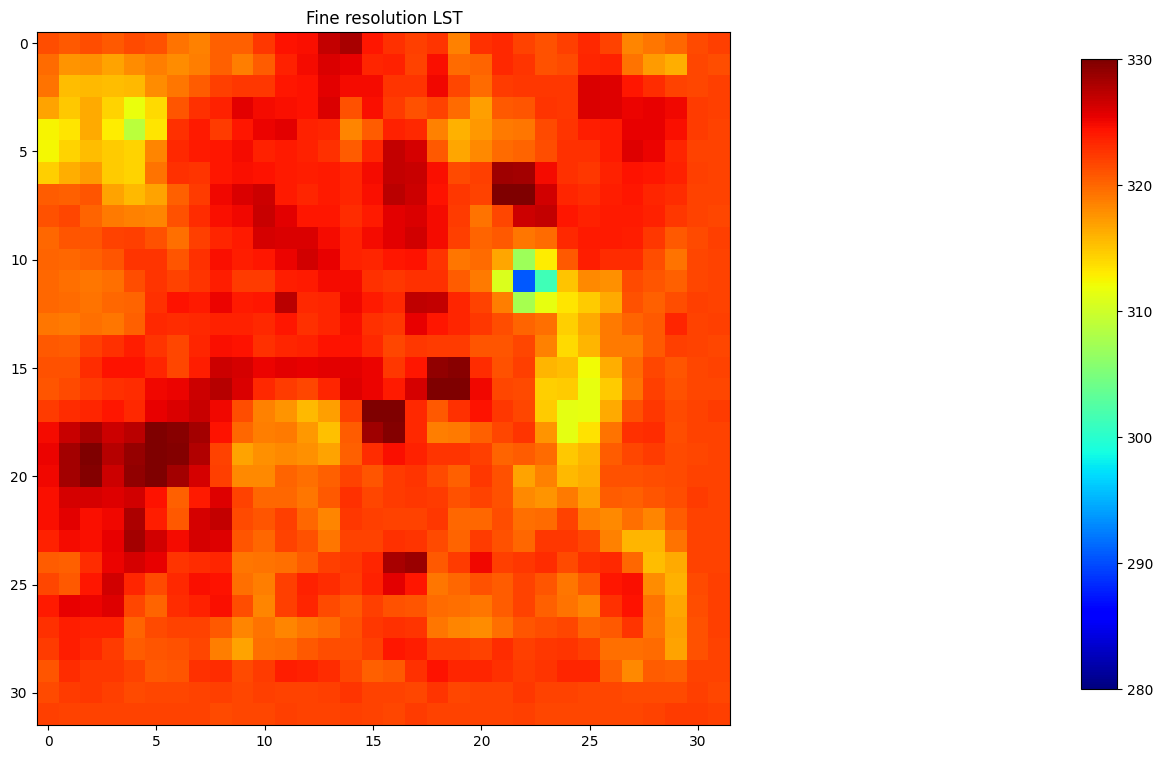

In [90]:
fig, ax0 = plt.subplots(nrows=1, ncols=1, sharex=False, figsize=(18, 9))

ax0.set_title('Fine resolution LST')
img=ax0.imshow(pred*sTc + mTc, vmin=280, vmax=330, cmap='jet')

fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.85, 0.15, 0.02, 0.7])
cbar=fig.colorbar(img, cax=cbar_ax)

plt.show()